# XGBoost

XGBoost stands for Extreme Gradient Boosting. It is considered the "state-of-the-art” machine learning algorithm to deal with structured data.

### Why use XGBoost?
Speed and performance : Originally written in C++, it is comparatively faster than other ensemble classifiers.

Core algorithm is parallelizable : Because the core XGBoost algorithm is parallelizable it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.

Consistently outperforms other algorithm methods : It has shown better performance on a variety of machine learning benchmark datasets.

Wide variety of tuning parameters : XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API etc.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,r2_score

In [9]:
df = pd.read_csv('data/variables.csv')

X = df.drop('maximum_range',axis=1)
y = df['maximum_range']

## Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

## Creating a Model

In [11]:
parameters={'n_estimators': [100, 1000, 5000],
            'max_depth': [2, 3, 6],
            'learning_rate': [0.1, 0.01],
            'subsample': [0.6, 0.8],
            'colsample_bytree': [0.8, 1],
            'gamma': [0, 1],
            'min_child_weight': [1, 2]}

In [12]:
model = XGBRegressor()

## Training the Model

In [13]:
model_grid = GridSearchCV(model, parameters, cv=5, verbose=1, scoring='r2', n_jobs = -1, return_train_score=True)
model_grid.fit(X_train,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/Users/dantas/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:19:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1], 'gamma': [0, 1],
                         'learning_rate': [0.1, 0.01], 'max_depth': [2, 3, 6],
                         'min_child_weight': [1, 2],
                         'n_estimators': [100, 1000, 5000],
                         'subsample': [0.6, 0.8]},
             return_train_score=True, scoring='r2', verbose=1)

In [14]:
# best parameters
model_grid.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 5000,
 'subsample': 0.8}

In [15]:
model = XGBRegressor(**model_grid.best_params_)

In [16]:
model.fit(X_train,y_train, eval_metric=['rmse'], eval_set = [(X_train, y_train), (X_test, y_test)], verbose=0, 
          early_stopping_rounds=30)

[03:20:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.01, max_depth=2, n_estimators=5000, subsample=0.8)

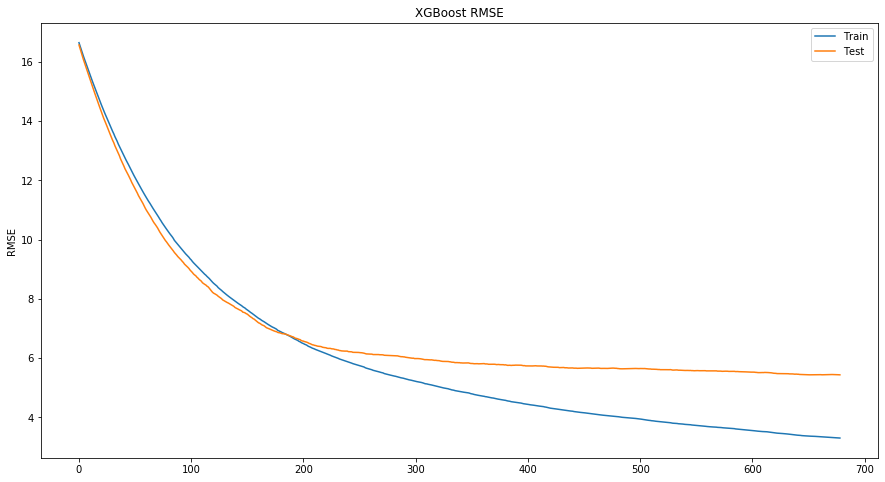

In [20]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot rmse
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE');

In [21]:
# make predictions for test data
predictions = model.predict(X_test)

In [22]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,r2_score

# Calculate the Explained Variance Score
print("Explained Variance Score: {:.3f}".format(explained_variance_score(predictions,y_test)))
# Calculate the R2
print("R2: {:.3f}".format(r2_score(y_test,predictions)))
# Calculate the Mean Abosolute Error
print("MAE: {:.3f}".format(mean_absolute_error(y_test,predictions)))
# Calculate the Mean Squared Error
print("MSE: {:.3f}".format(mean_squared_error(y_test,predictions)))
# Calculate the Root Mean Squared Error
print("RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_test,predictions))))

Explained Variance Score: 0.517
R2: 0.685
MAE: 4.334
MSE: 29.559
RMSE: 5.437


In [23]:
df[['maximum_range']].describe().T

,count,mean,std,min,25%,50%,75%,max
maximum_range,210.0,13.592262,10.47767,0.078125,6.171875,9.6875,21.484375,40.703125


In [24]:
# Calculate the Mean and Standard Deviation of the Air Superiority Index
print("Mean of MR: {:.3f}".format(y.mean()))
print("STD of MR: {:.3f}".format(y.std()))

Mean of MR: 13.592
STD of MR: 10.478


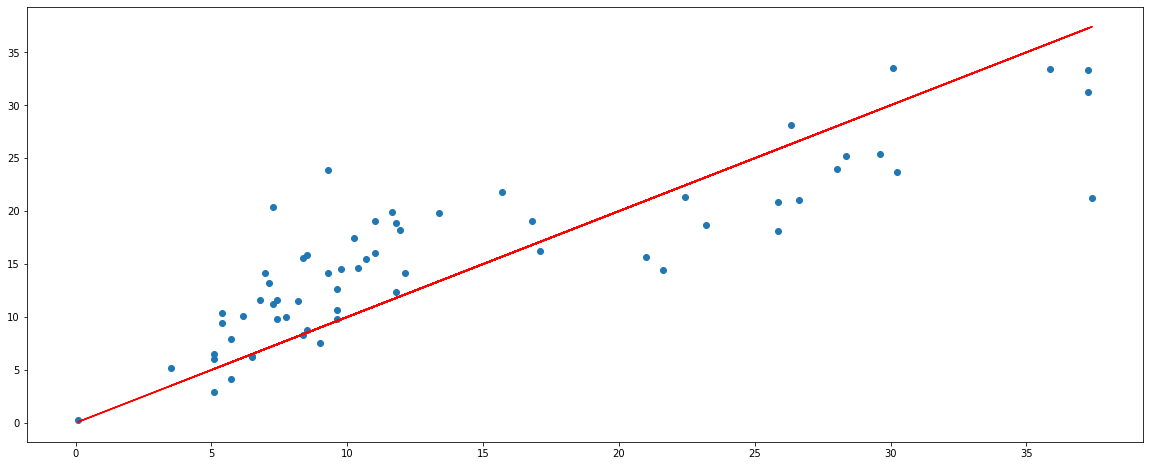

In [25]:
plt.figure(figsize=(20,8))

# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r');

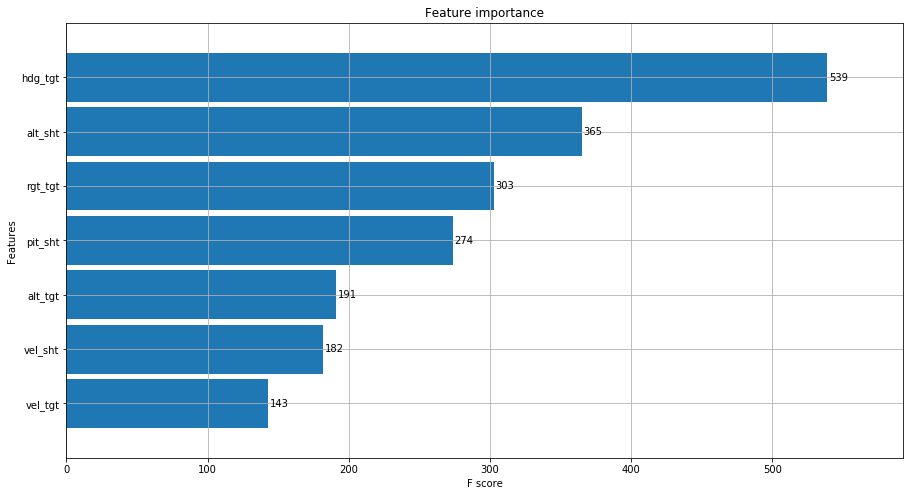

In [26]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (15,8)

_ = plot_importance(model, height=0.9)

### Saving the model

In [37]:
import joblib

# save model to file
joblib.dump(model, 'models/xgboost_model.dat');

## Evaluation the Learning Curve

In [30]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(model,
                                           X, y, cv=5, scoring='r2', n_jobs=-1,
                                           # 50 different sizes of the training set
                                           train_sizes=np.linspace(0.01, 1.0, 50))

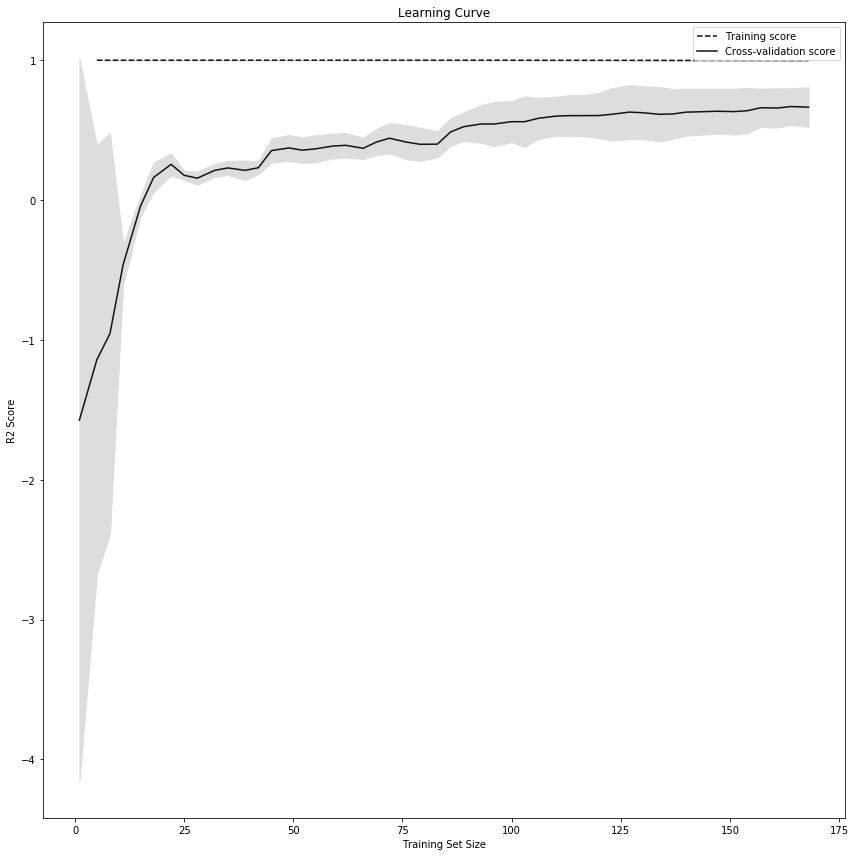

In [31]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.subplots(1, figsize=(12,12))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R2 Score")
plt.legend(loc="best")
plt.tight_layout();

## Deployment

In [32]:
# Taking a sample
X_sample = df.drop('maximum_range', axis=1).iloc[0:1]
y_sample = df['maximum_range'].iloc[0:1]

In [33]:
X_sample.shape

(1, 7)

In [34]:
X_sample

,alt_sht,vel_sht,alt_tgt,vel_tgt,hdg_tgt,rgt_tgt,pit_sht
0,17696.615077,513.351198,19981.121005,491.701066,73.93298,-1.218574,-3.051489


In [35]:
y_sample

0    8.671875
Name: maximum_range, dtype: float64

In [39]:
import joblib

#load model from file
loaded_model = joblib.load('models/xgboost_model.dat')

[03:24:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
# make predictions for test data
y_pred = loaded_model.predict(X_sample)

In [41]:
# predicted Value
y_pred[0]

8.369657

In [42]:
# true Valeu
df['maximum_range'].iloc[0]

8.671875